# Local level model

This note uses a local level model. Basic state-space model with measurement error and an AR(1) latent process.

$$y_t = \gamma + \eta z_t + \epsilon_t, \quad \epsilon_t \sim N_{0,\sigma^2}, \quad t=1,\dots,\tau$$
$$z_t = \rho z_{t-1} + \nu_t\quad \nu_t \sim N_{0,1}, \quad t=2,\dots,\tau$$
$$z_1 \sim N_{0, (1+\rho^2)^{-1/2}} $$

See the graphs below and code for information about the priors and inference, which is a structured (full-rank) VI procedure.

## Preliminaries

In [1]:
# !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl >/dev/null && echo OK
# !pip3 install torchvision > /dev/null && echo OK
# !pip3 uninstall -y ptvi >/dev/null && echo OK
# !pip3 install git+https://github.com/kuperov/ptvi.git  >/dev/null && echo OK

In [1]:
from ptvi import *
import torch
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('precision', 2)
plt.rcParams['figure.figsize'] = [12, 8]

Define the true parameter values and generate data.

In [2]:
γ0, η0, σ0, ρ0 = 0., 2., 1.5, 0.92

In [3]:
torch.manual_seed(123)
params = {'γ': γ0, 'η': η0, 'σ': σ0, 'ρ': ρ0}
y, z = LocalLevelModel(input_length=100).simulate(**params)

## MAP inference

In [4]:
model = LocalLevelModel(input_length=100, quiet=False)
ζ = model.map(y)
θ = model.unpack(ζ)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
MAP inference with L-BGFS: Local level model
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. ll = -1106.6174
       1. ll = -368.8922
       2. ll = -259.3571
       3. ll = -251.2169
       4. ll = -251.1165
       5. ll = -251.1164
Convergence criterion met.
       5. ll = -251.1164
Completed 6 iterations in 0.13s @ 45.08 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


## Approximate inference

Our inference procedure is quick, but frankly not super great.

There are two different ways to compute elbo estimates. The first is ADVI, where our elbo is estimated with an analytic entropy term, as

$$ \hat{\mathcal{L}} = \frac{1}{M} \sum_{i=1}^M 
    p(y, \zeta^{(i)}) - 
    \mathbb{E}_{q_{u,L}} \left[ q_{u,L}(\zeta^{(i)}) 
   \right]
$$
where $\zeta^{(i)}\sim q_{u,L}$ via the reparameterization trick. 

The other is SGVI, where the elbo is estimated by simulating the entropy term, as

$$ \hat{\mathcal{L}} = \frac{1}{M} \sum_{i=1}^M \left[
    p(y, \zeta^{(i)}) - q_{u,L}(\zeta^{(i)}) 
   \right]
$$
where $\zeta^{(i)}\sim q_{u,L}$ via the reparameterization trick. 

The code is available [here](https://github.com/kuperov/ptvi/blob/dev/ptvi/local_level.py).

In [5]:
model = LocalLevelModel(input_length=100, stochastic_entropy=True, num_draws=1)
fit = model.training_loop(y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference

Local level model:
  - input length 100
  - Stochastic entropy term with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0

Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo_hat =     -324.42
       1. smoothed elbo_hat =     -323.28
       2. smoothed elbo_hat =    -2238.71
       4. smoothed elbo_hat =    -3255.37
       8. smoothed elbo_hat =    -2717.10
      16. smoothed elbo_hat =    -8092.79
      32. smoothed elbo_hat =    -4237.69
      64. smoothed elbo_hat =    -5476.72
     128. smoothed elbo_hat =    -4380.71
     256. smoothed elbo_hat =    -3494.23
     512. smoothed elbo_hat =    -5887.29
    1024. smoothed elbo_hat =     -559.27
    2048. smo

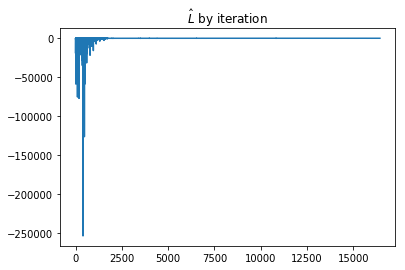

In [6]:
fit.plot_elbos()

In [7]:
fit.summary()

,mean,sd
γ,-0.09,0.64
η,1.60,0.25
σ,2.04,0.29
ρ,0.90,0.05


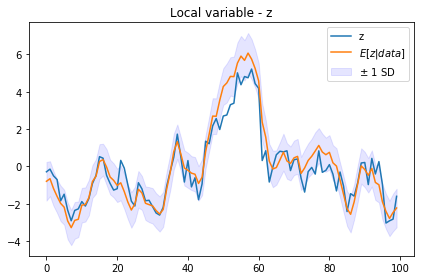

In [10]:
fit.plot_latent(z=z)

## Global variables: marginal posteriors

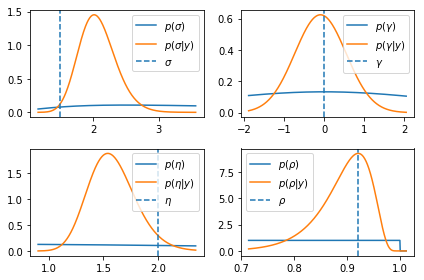

In [10]:
plt.plot_global_marginals(**params)

### Forecasts

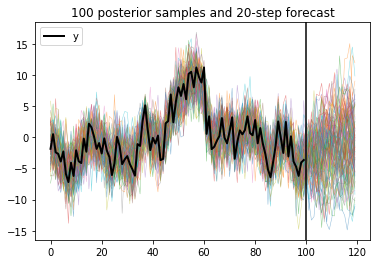

In [11]:
fit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

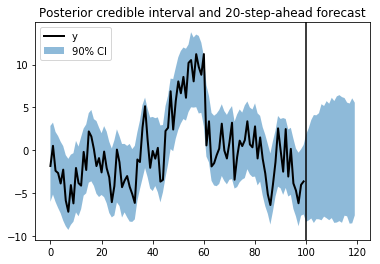

In [12]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)

### Subsequent training runs?

What happens when we start training at the values we found last time?

In [13]:
fit = model.training_loop(y)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference

Local level model:
  - input length 100
  - Stochastic entropy term with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0

Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo_hat =     -294.67
       1. smoothed elbo_hat =     -291.13
       2. smoothed elbo_hat =     -288.31
       4. smoothed elbo_hat =     -282.63
       8. smoothed elbo_hat =     -273.87
      16. smoothed elbo_hat =     -264.31
      32. smoothed elbo_hat =     -260.34
      64. smoothed elbo_hat =     -257.21
     128. smoothed elbo_hat =     -258.91
     256. smoothed elbo_hat =     -258.51
     512. smoothed elbo_hat =     -260.08
    1024. smoothed elbo_hat =     -261.05
    2048. smo

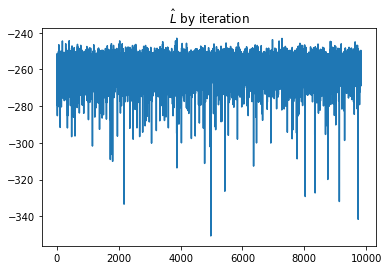

In [14]:
fit.plot_elbos()